In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report, roc_auc_score,roc_curve
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
'for better orgnization, define a funcion to generate report for each model'
def report_generator(classifier, X_test, Y_test):
  if classifier == xgb_trained:
    dtest = xgb.DMatrix(X_test, label=Y_test)
    Y_pred = classifier.predict(dtest)
  else:
    Y_pred = classifier.predict(X_test)
  #RMSE
  RMSE = np.sqrt(mean_squared_error(Y_test, Y_pred))
  print("RMSE:", RMSE)
  print()

  #MAPE
  MAPE = np.average(np.abs((Y_test.values - Y_pred) / Y_test.values))
  print("MAPE:", MAPE)
  print()

  #DA
  Y_test_DA = np.array(Y_test)
  Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
  Y_test_0 = Y_test[1:] - Y_test_DA[:-1]
  DA = (Y_pred_0<0) == (Y_test_0<0)
  print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")

  return RMSE, MAPE, DA

In [ ]:
def data_preprocessor(path):
    total = pd.read_csv(path)
    total = total.loc[:2558,:]
    #total = total.fillna(method='ffill')
    total = total.ffill().bfill()
    for index in total.index:
        total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%Y/%m/%d').date()
    '''#Period 1
    Start_day = date(2015, 8, 7)
    Test_day = date(2018, 4, 1)
    End_day = date(2018, 9, 30)

    # train, test
    total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day) ].reset_index(drop = True)
    train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
    test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)
    '''

    #period 2
    Start_day = date(2018, 10, 1)
    Test_day = date(2021, 10, 1)

    total = total[total["Date"] >= Start_day].reset_index(drop = True)
    train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
    test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)

    X_train = train_dataset.drop(["Date"], axis=1)[:-1]
    Y_train = train_dataset["BTC_Close"][1:]

    X_test = test_dataset.drop(["Date"], axis=1)[:-1]
    Y_test = test_dataset["BTC_Close"][1:]
    return X_train,Y_train,X_test,Y_test

X_train,Y_train,X_test,Y_test = data_preprocessor("jrfm_log_diff.csv")



In [ ]:
X_train.size
len(X_train.columns)
len(X_train)

967

SVM

In [ ]:
''' too slow
def svm_model(X_train,Y_train, kernel = 'linear', gamma = 'auto'):
    from sklearn.svm import SVR
    clf = SVR(kernel='linear',gamma = 'auto')
    clf.fit(X_train,Y_train)
    return clf

clf = svm_model(X_train,Y_train, kernel = 'linear', gamma = 'auto')
report_generator(clf, X_test, Y_test)
'''

KNN

In [ ]:
def find_best_k(X_tr, y_tr):
    max_score = 0
    best_k = 0
    for i in range(1,10):
        clf = KNeighborsRegressor(n_neighbors=i).fit(X_tr, y_tr)
        Y_pred = clf.predict(X_tr)
        #metric: RMSE
        #RMSE = np.sqrt(mean_squared_error(y_tr, Y_pred))
        #metric: DA
        Y_test_DA = np.array(y_tr)
        Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
        Y_test_0 = y_tr[1:] - Y_test_DA[:-1]
        DA = (Y_pred_0<0) == (Y_test_0<0)
        DA = np.mean(DA)*100
        if DA > max_score:
            best_k = i
            max_score = DA
    print("The best in-sample k is:",best_k)
    return best_k

def knn(X_tr, y_tr,X_val,y_val):
    k = find_best_k(X_tr, y_tr)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_tr, y_tr)
    return knn


In [ ]:
knn_trained = knn(X_train,Y_train,X_test,Y_test)
report_generator(knn_trained,X_test,Y_test )

The best in-sample k is: 1
RMSE: 0.06220486340877044

MAPE: 6.701194519668313

DA accuracy: 52.22%


(0.06220486340877044,
 6.701194519668313,
 2       True
 3       True
 4       True
 5       True
 6       True
        ...  
 177     True
 178    False
 179     True
 180    False
 181    False
 Name: BTC_Close, Length: 180, dtype: bool)

In [ ]:
import statsmodels.api as sm

def binomial_GLM(X_train,Y_train,X_test,Y_test):
  X_train_with_intercept = sm.add_constant(X_train)
  Y_train.reset_index(drop=True, inplace=True)
  Y_train = (Y_train > 0).astype(int)
  X_train_with_intercept.reset_index(drop=True, inplace=True)
  # Create a binomial GLM model
  binomial_glm = sm.GLM(Y_train, X_train_with_intercept, family=sm.families.Binomial())

  # Fit the model
  binomial_results = binomial_glm.fit()

  # Display the summary of the model
  print(binomial_results.summary())

  # Assuming X_test is your test data
  X_test_with_intercept = sm.add_constant(X_test)

  # Make predictions on the test data
  predictions = binomial_results.predict(X_test_with_intercept)

  Y_test = (Y_test > 0).astype(int)
  DA = (np.array(predictions)>0) == (Y_test>0)
  print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")
  return np.mean(DA)*100

In [ ]:
binomial_GLM(X_train,Y_train,X_test,Y_test)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              BTC_Close   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1049
Model Family:                Binomial   Df Model:                           45
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -725.12
Date:                Thu, 07 Dec 2023   Deviance:                       1450.2
Time:                        18:02:20   Pearson chi2:                 1.10e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05646
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

50.27624309392266

XGBoost

In [ ]:
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
num_round = 100
#model = xgb.XGBClassifier(params,num_round)
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [ ]:
xgb_trained = xgb.train(params, dtrain, num_round)
predictions = xgb_trained.predict(dtest)
print(predictions)

[ 0.00907269 -0.04306473 -0.01545988  0.01397045 -0.0069573   0.04132611
  0.0064553  -0.00812142 -0.00448412 -0.00685149 -0.00438613 -0.0046996
 -0.01343139 -0.01701591  0.03845403 -0.02111879 -0.00091426  0.0002927
 -0.00260664 -0.00413563 -0.01744935  0.03452827 -0.01221706 -0.00197348
 -0.00394153  0.0238767   0.01128763  0.03075836 -0.02118691 -0.02736741
 -0.01654187 -0.01159883 -0.00858786  0.00235657 -0.02762642 -0.00930182
  0.01152488 -0.00953194 -0.00949172  0.01744786 -0.0170002   0.00174438
  0.0103659   0.0090464   0.00570221 -0.01438546  0.03604484 -0.01224538
  0.00831518 -0.01533127 -0.00580026 -0.00798077 -0.00219403  0.01018991
  0.00883411 -0.01848068 -0.00396847 -0.0194366  -0.03296648  0.002191
 -0.02371857 -0.00386411  0.01668331 -0.01804383  0.00684055 -0.07775722
 -0.00202281 -0.01659583  0.02289178 -0.00285034  0.00740747 -0.00254039
 -0.00828821 -0.02115916 -0.01924599  0.00804316  0.0017226   0.00408002
 -0.01764645  0.02572938 -0.03735399 -0.0129107  -0.014

In [ ]:
report_generator(xgb_trained,X_test,Y_test)

RMSE: 0.03777114401445689

MAPE: 2.090955603796224

DA accuracy: 70.56%


(0.03777114401445689,
 2.090955603796224,
 2      False
 3      False
 4      False
 5      False
 6       True
        ...  
 177     True
 178     True
 179     True
 180     True
 181    False
 Name: BTC_Close, Length: 180, dtype: bool)

In [ ]:

data = pd.read_csv("jrfm-2156907.csv",index_col=0)
print(data.iloc[:2558,:].head())
data = data.iloc[:2558,: ]
data = data.fillna(method='ffill')



# Calculate differences along axis 0 (rows)
row_differences = np.diff(np.log(data), axis=0)

print("Differences along Rows:")
row_differences

col_names = data.columns.tolist()
index = data.index.tolist()[1:]
len(index)

df = pd.DataFrame(row_differences,columns=col_names)
df.iloc[:,-7:] = np.diff(data.iloc[:,-7:], axis=0)
print(len(df.index.tolist()))
df.insert(0, 'Date', np.array(index))
#df = df.set_index(np.array(index1))
df.to_csv('jrfm_log_diff.csv')


In [ ]:
print(len(predictions))
real_X_train,real_Y_train,real_X_test,real_Y_test = data_preprocessor("jrfm-2156907.csv")
print(len(real_Y_test))
real = list(real_Y_test)

181
182


In [ ]:
accum_return_list = [1]
return_list = []
accum_r = real_accum_r = 1
real_return = []
real_accum_return = [1]
for i in range(181):
  r = (real[i+1]-real[i])/real[i]
  if predictions[i]>0:
    return_list.append(r)
    accum_r *= (1+r)
  else:
    return_list.append(-r)
    accum_r *= (1-r)
  accum_return_list.append(accum_r)
  real_accum_r *= (1+r)
  real_return.append(r)
  real_accum_return.append(real_accum_r)



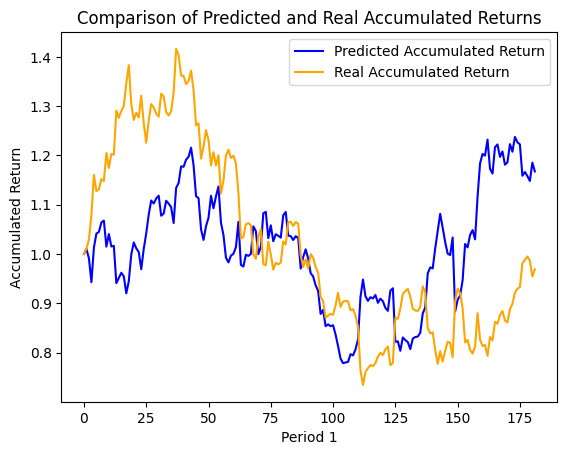

In [ ]:
plt.plot(accum_return_list,color = 'blue', label='Predicted Accumulated Return')
plt.plot(real_accum_return,color = 'orange', label='Real Accumulated Return')

# Adding a title
plt.title('Comparison of Predicted and Real Accumulated Returns')

# Adding labels for the X and Y axes
plt.xlabel('Period 1')
plt.ylabel('Accumulated Return')

# Adding a legend to distinguish between the two lines
plt.legend()

# Finally, show the plot
plt.show()

In [ ]:
import numpy as np

# Assuming daily_return_list contains daily returns of your trading strategy
daily_return_list = np.array(return_list)  # Convert to a numpy array if it's not

# Sharpe Ratio
risk_free_rate = 0  # Assuming 0 for simplicity
average_daily_return = np.mean(daily_return_list)
std_dev = np.std(daily_return_list)
sharpe_ratio = (average_daily_return - risk_free_rate) / std_dev

# Annual Return
annual_return = (1 + average_daily_return) ** 365 - 1

# Volatility
volatility = std_dev * np.sqrt(365)

# Maximum Drawdown
cumulative_returns = np.cumprod(1 + daily_return_list) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak)
max_drawdown = np.min(drawdown)

# Print the metrics
print('average_daily_return',average_daily_return)
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Annual Return: {annual_return}")
print(f"Volatility: {volatility}")
print(f"Maximum Drawdown: {max_drawdown}")


average_daily_return 0.0014237218786366992
Sharpe Ratio: 0.042501196396243154
Annual Return: 0.6808320049462895
Volatility: 0.6399859440608158
Maximum Drawdown: -0.4373387553229472


In [ ]:
1.0014**365

1.666361710798184